# Spark RDD

## Setup

In [72]:
import operator
import re
from typing import Tuple

import cartopy.crs as crs
import ipinfo
import matplotlib.pyplot as plt
import findspark
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns
import urllib.request

### Spark initialization

In [73]:
findspark.init()
spark = SparkSession \
    .builder \
    .config("spark.sql.catalogImplementation", "in-memory") \
    .getOrCreate()
sc = spark.sparkContext
spark

### Get dataset

Dataset consists of Apache server logs with web clients that connected to that server.

In [74]:
url = "http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs"
filename = "apache_logs"

urllib.request.urlretrieve(url, filename)

('apache_logs', <http.client.HTTPMessage at 0x174533147f0>)

In [75]:
data = sc.textFile(filename)
data.collect()[:2]

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"']

## Most popular web pages

Plot ranking of the most popular web pages (referer), except for the `semicomplete.com` domain.

In [76]:
link_regex = r"https?://(:?www\.|)(.*?)(/|\")|\"-\""
top_k = 10

link_counts = (data
    .filter(lambda log: "semicomplete.com" not in log)
    .map(lambda log: (re.search(link_regex, log).group(2), 1))
    .filter(lambda x: x[0])
    .reduceByKey(operator.add)
    # x = (link, count)
    .takeOrdered(top_k, lambda x: -x[1])
)

link_counts

[('google.com', 144),
 ('s-chassis.co.nz', 51),
 ('stackoverflow.com', 34),
 ('logstash.net', 31),
 ('google.co.uk', 24),
 ('google.fr', 15),
 ('google.de', 13),
 ('google.co.in', 13),
 ('tuxradar.com', 12),
 ('en.wikipedia.org', 10)]

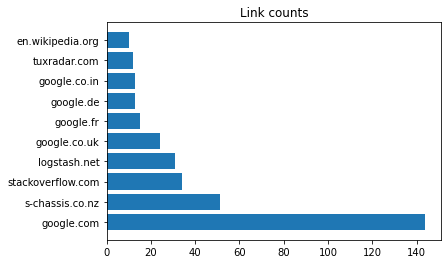

In [77]:
xs = [link for (link, count) in link_counts]
ys = [count for (link, count) in link_counts]

plt.barh(xs, ys)
plt.title("Link counts")
plt.show()

## Requests per hour per response code

Plot number of requests per hour, grouped by response code (202, 404 etc.).

In [78]:
hour_regex = "\[\d+/\w+/\d+:(\d+):"
response_code_regex = "\"(GET|HEAD|POST|OPTIONS).*?\" (\d+)"

def get_hour_and_response_code(log: str) -> Tuple[int, int, int]:
    hour = int(re.search(hour_regex, log).group(1))
    response_code = int(re.search(response_code_regex, log).group(2))
    return (hour, response_code), 1

requests_counts = (data
    .map(lambda log: get_hour_and_response_code(log))
    .reduceByKey(operator.add)
    # x[0] = (hour, response_code), x[1] = count
    .map(lambda x: [x[0][0], x[0][1], x[1]])
    .collect()
)

for requests_count in requests_counts[:5]:
    print(requests_count)

[10, 200, 418]
[10, 404, 11]
[11, 301, 2]
[12, 200, 418]
[12, 304, 8]


<AxesSubplot:xlabel='hour', ylabel='count'>

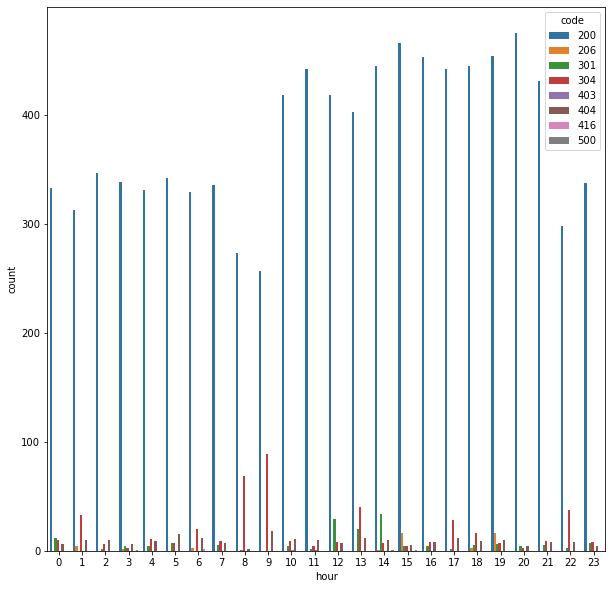

In [79]:
df = pd.DataFrame(
    data=requests_counts,
    columns=["hour", "code", "count"]
)

plt.figure(figsize=[10, 10])
sns.barplot(data=df, x="hour", y="count", hue="code")

## Most used resource types

Plot ranking of the most used resource by file type (html, css, png, etc.).

In [80]:
file_type_regex = "\"GET \S+\.([a-zA-Z]+) "
top_k = 10

def get_file_type(log: str) -> Tuple[str, int]:
    file_type = re.search(file_type_regex, log)
    return (file_type.group(1), 1) if file_type else ("", 0)


resource_type_counts = (data
    .filter(lambda log: "GET" in log)
    .map(lambda log: get_file_type(log))
    .reduceByKey(operator.add)
    .filter(lambda x: x[1] > 0)  # remove "empty" links count
    .takeOrdered(top_k, lambda x: -x[1])
)

resource_type_counts[:5]

[('png', 2331), ('css', 1458), ('ico', 800), ('html', 753), ('jpg', 257)]

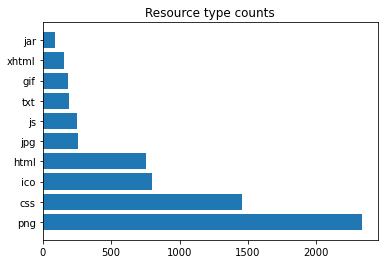

In [82]:
xs = [res_type for (res_type, count) in resource_type_counts]
ys = [count for (res_type, count) in resource_type_counts]

plt.barh(xs, ys)
plt.title("Resource type counts")
plt.show()

## Plot clients geolocation

Plot map with geographic locations of clients.

In [44]:
ip_regex = "[(\d\.)]+"

ips = (data
    .map(lambda log: re.match(ip_regex, log).group(0))
    .distinct()
    .collect()
)

ips[:5]

['83.149.9.216',
 '110.136.166.128',
 '46.105.14.53',
 '123.125.71.35',
 '200.49.190.100']

In [45]:
access_token = "e2129d74bb4a2b"
ipinfo_handler = ipinfo.getHandler(access_token=access_token)

ipinfo_response = ipinfo_handler.getBatchDetails(ips)
locations = [
    details["loc"].split(",") 
    for details in ipinfo_response.values()
]

locations = [(float(lat), float(long)) for lat, long in locations]
locations[:5]

[(55.7522, 37.6156),
 (-6.9931, 110.4208),
 (39.9075, 116.3972),
 (14.6407, -90.5133),
 (37.7749, -122.4194)]

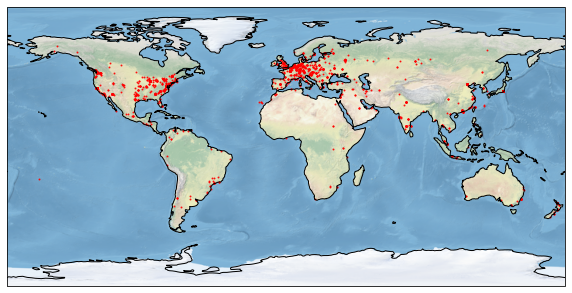

In [49]:
plt.figure(figsize=[10, 10])
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()

lats = [lat for (lat, long) in locations]
longs = [long for (lat, long) in locations]

plt.scatter(
    x=longs,
    y=lats,
    color="r",
    s=1,
    alpha=0.8,
    transform=crs.PlateCarree()
)

plt.show()

## Bots estimation

Estimate percentage of traffic generated by bots.

List of bots taken from [this page](https://www.sumologic.com/insight/apache-logs-identifying-robots/).

In [70]:
user_agent_regex = "\"(.*?)\""
bots_set = {"Googlebot", "AskJeeves", "Digger", "Lycos", "msnbot",
    "Inktomi Slurp", "Yahoo", "Nutch", "bingbot", "BingPreview",
    "Mediapartners-Google", "proximic", "AhrefsBot", "AdsBot-Google",
    "Ezooms", "AddThis.com", "facebookexternalhit", "MetaURI",
    "Feedfetcher-Google", "PaperLiBot", "TweetmemeBot", "Sogou web spider",
    "GoogleProducer", "RockmeltEmbedder", "ShareThisFetcher", "YandexBot",
    "rogerbot-crawler", "ShowyouBot", "Baiduspider", "Sosospider", "Exabot"
}

bot_count = (data
    .filter(lambda log: any(bot in log for bot in bots_set))
    .count()
)

bot_perc = 100 * (bot_count / data.count())
print(f"Estimated bot percentage: {bot_perc:.2f}%")

Estimated bot percentage: 13.47%
